In [2]:
!pip install tflearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 107 kB 7.3 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=fdc8938ac3398deefaa02c01dad766edadae32cd7c1f88e1aaeefb6e86bb5d7c
  Stored in directory: /root/.cache/pip/wheels/65/9b/15/cb1e6b279c14ed897530d15cfd7da8e3df8a947e593f5cfe59
Successfully built tflearn


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tflearn.data_utils as du
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
train_data = pd.read_csv('/content/csvTrainImages 13440x1024.csv', header = None)
train_label = pd.read_csv('/content/csvTrainLabel 13440x1.csv', header = None)
test_data = pd.read_csv('/content/csvTestImages 3360x1024.csv', header = None)
test_label = pd.read_csv('/content/csvTestLabel 3360x1.csv', header = None)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 105.0 MB


In [6]:
train_data = train_data.iloc[:,:].values.astype('float32')
train_label = train_label.iloc[:,:].values.astype('int32')-1
test_data = test_data.iloc[:,:].values.astype('float32')
test_label = test_label.iloc[:,:].values.astype('int32')-1

In [7]:
def row_calculator(number_of_images, number_of_columns):
    if number_of_images % number_of_columns != 0:
        return (number_of_images / number_of_columns)+1
    else:
        return (number_of_images / number_of_columns)

In [8]:
def display_image(x, img_size, number_of_images):
    plt.figure(figsize = (8, 7))
    if x.shape[0] > 0:
        n_samples = x.shape[0]
        x = x.reshape(n_samples, img_size, img_size)
        number_of_rows = row_calculator(number_of_images, 4)
        for i in range(number_of_images):
            plt.subplot(number_of_rows, 4, i+1)
            plt.imshow(x[i])

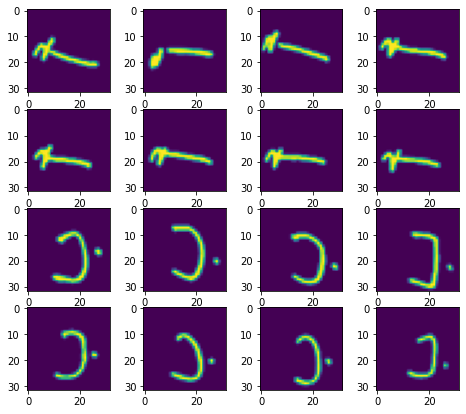

In [9]:
display_image(train_data, 32, 16)

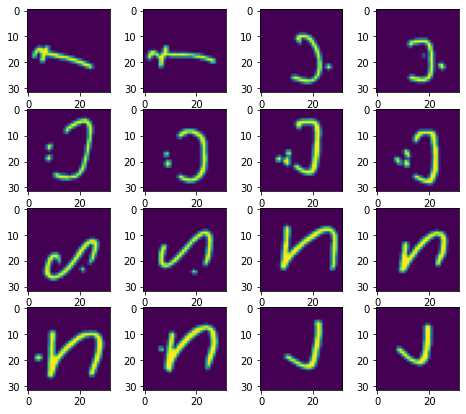

In [10]:
display_image(test_data, 32, 16)

In [11]:
train_label = du.to_categorical(train_label,28)

In [12]:
train_data = train_data/255
test_data = test_data/255

In [13]:
train_data = train_data.reshape([-1, 32, 32, 1])
test_data = test_data.reshape([-1, 32, 32, 1])

In [14]:
train_data, mean1 = du.featurewise_zero_center(train_data)
test_data, mean2 = du.featurewise_zero_center(test_data)

In [15]:
recognizer = Sequential()

recognizer.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (32,32,1)))
recognizer.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
recognizer.add(MaxPool2D(pool_size=(2,2)))
recognizer.add(Dropout(0.25))


recognizer.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
recognizer.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
recognizer.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
recognizer.add(Dropout(0.25))


recognizer.add(Flatten())
recognizer.add(Dense(units = 256, input_dim = 1024, activation = 'relu'))
recognizer.add(Dense(units = 256, activation = "relu"))
recognizer.add(Dropout(0.5))
recognizer.add(Dense(28, activation = "softmax"))

In [16]:
recognizer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

In [17]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [18]:
recognizer.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

In [20]:
datagen.fit(train_data)

In [ ]:
recognizer.fit_generator(datagen.flow(train_data,train_label, batch_size=100),
                             epochs = 30, verbose = 2, steps_per_epoch=train_data.shape[0] // 100)